# 1.4 - Stopping Criteria

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

import numpy as np
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

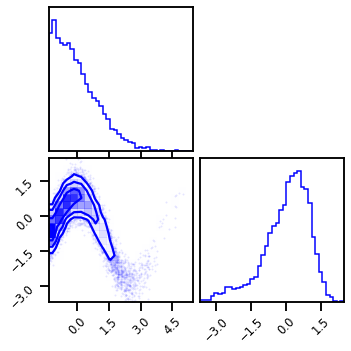

In [3]:
from rbig_jax.data import get_classic
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 10_000
n_features = 2
data = get_classic(n_samples, seed=123)
data = StandardScaler().fit_transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [4]:
X = np.array(data, dtype=np.float32)

## Gaussianization Flow Model

In [5]:
from rbig_jax.transforms.block import init_default_rbig_block

support_extension = 10
alpha = 1e-5
precision = 100
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = True

# init rbig_block
rbig_block = init_default_rbig_block(n_samples=X.shape[0])

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [6]:
from rbig_jax.transforms.kde import InitUniKDETransform

# KDE Transform
support_extension = 20
alpha = 1e-5
precision = 1_000
bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")

init_hist_f = InitUniKDETransform(
    shape=X.shape, support_extension=support_extension, precision=precision, bw=bw
)

from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDFTransform(eps=eps)

from rbig_jax.transforms.rotation import InitPCARotation

# initialize histogram transformation
init_pca_f = InitPCARotation(jitted=True)


# initialize rbig block
init_functions = [init_hist_f, init_icdf_f, init_pca_f]

from rbig_jax.transforms.block import RBIGBlock

rbig_block = RBIGBlock(init_functions=init_functions)

## Training

### Fixed Number of Layers

#### State Management


In [7]:
from chex import dataclass


@dataclass
class MaxLayers:
    max_layers: int
    ilayer: int


def init_max_layers_loss(max_layers: int = 20):
    def condition(state):

        return state.ilayer < state.max_layers

    #     def update_state(ilayer, max_layers):

    #         return

    return MaxLayers(max_layers=max_layers, ilayer=0), condition

In [8]:
%%time

import itertools

# itercount = itertools.count(-1)

max_layers = 20
train_state, condition = init_max_layers_loss(max_layers=max_layers)

# init rbig_block
X_g = X.copy()
rbig_block = init_default_rbig_block(n_samples=X.shape[0])

CPU times: user 1.2 ms, sys: 0 ns, total: 1.2 ms
Wall time: 1.14 ms


In [9]:
bijectors = list()

while condition(train_state):

    # fit RBIG block
    X_g, ibijector = rbig_block.forward_and_params(X_g)

    #     fig = corner.corner(X_g, color="blue", hist_bin_factor=2)

    # append bijectors
    bijectors += ibijector

    train_state = MaxLayers(
        max_layers=train_state.max_layers, ilayer=train_state.ilayer + 1
    )

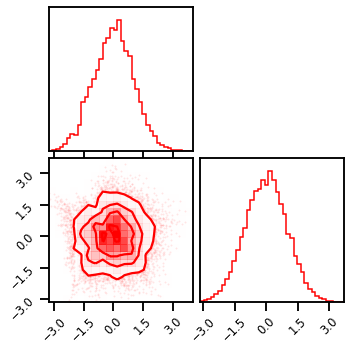

In [10]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

### Negative Log-Likelihood Loss

In [11]:
from rbig_jax.information.total_corr import init_information_reduction_loss

info_loss_f = jax.jit(
    init_information_reduction_loss(n_samples=X.shape[0], base=2, p=0.25)
)

### Information Loss

In [12]:
from chex import Array, dataclass


@dataclass
class InfoLossState:
    max_layers: int
    ilayer: int
    info_loss: Array


# def info_loss_condition(state):

#     # rolling average
#     x_cumsum_window = np.convolve(jnp.abs(state.info_loss), window, "valid")

#     n_zeros = int(jnp.sum(np.where(x_cumsum_window > 0.0, 0, 1)))
#     print(jax.lax.ne(n_zeros, 1), state.ilayer, state.max_layers)
#     return jax.lax.ne(n_zeros, 1) or state.ilayer < state.max_layers


def init_info_loss(
    max_layers: int = 50,
    zero_tolerance: int = 5,
    n_samples: int = 1_000,
    jitted: bool = True,
    **kwargs,
):

    window = jnp.ones(zero_tolerance) / zero_tolerance

    # intialize condition
    def info_loss_condition(state):

        # rolling average
        x_cumsum_window = jnp.convolve(jnp.abs(state.info_loss), window, "valid")

        n_zeros = jnp.sum(jnp.where(x_cumsum_window > 0.0, 0, 1)).astype(jnp.int32)
        #         print(jax.lax.ne(n_zeros, 1), state.ilayer, state.max_layers)
        #         print(jax.lax.ne(n_zeros, 1), state.ilayer < state.max_layers)
        return jnp.logical_and(jax.lax.ne(n_zeros, 1), state.ilayer < state.max_layers)

    #         return jax.lax.cond(
    #             (jax.lax.ne(n_zeros, 1) & state.ilayer < state.max_layers), True, False
    #         )

    # intialize loss function
    info_loss_f = init_information_reduction_loss(n_samples=n_samples, **kwargs)
    if jitted:
        info_loss_f = jax.jit(info_loss_f)
        info_loss_condition = jax.jit(info_loss_condition)

    # intialize state
    info_loss_state = InfoLossState(
        max_layers=max_layers, ilayer=0, info_loss=jnp.ones(max_layers)
    )
    return info_loss_f, info_loss_condition, info_loss_state

In [13]:
max_layers = 100
zero_tolerance = 30
p = 0.25
base = 2
# initialize training
loss_f, cond, state = init_info_loss(
    n_samples=X.shape[0],
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
)

# init rbig_block
X_g = X.copy()

bijectors = list()

while cond(state):

    # fit loss partially
    layer_loss = jax.partial(info_loss_f, X_before=X_g)

    # fit RBIG block
    X_g, ibijector = rbig_block.forward_and_params(X_g)

    # get information reduction
    layer_loss = layer_loss(X_after=X_g)

    # update layer loss
    info_losses = jax.ops.index_update(state.info_loss, state.ilayer, layer_loss)

    # append bijectors
    bijectors += ibijector
    if state.ilayer % 5 == 0:
        print(f"Layer {state.ilayer+1} Loss: {info_losses[:state.ilayer+1].sum():.3f}")

    state = InfoLossState(
        max_layers=state.max_layers, ilayer=state.ilayer + 1, info_loss=info_losses,
    )


# get final loss
final_loss = info_losses[: state.ilayer]

Layer 1 Loss: 0.000
Layer 6 Loss: 0.453
Layer 11 Loss: 0.453
Layer 16 Loss: 0.499
Layer 21 Loss: 0.512
Layer 26 Loss: 0.512
Layer 31 Loss: 0.512
Layer 36 Loss: 0.512
Layer 41 Loss: 0.512
Layer 46 Loss: 0.512


In [14]:
len(bijectors) // state.ilayer

3

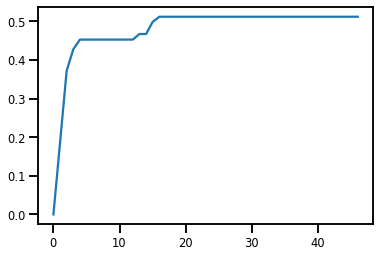

In [15]:
plt.plot(np.cumsum(final_loss))
plt.show()

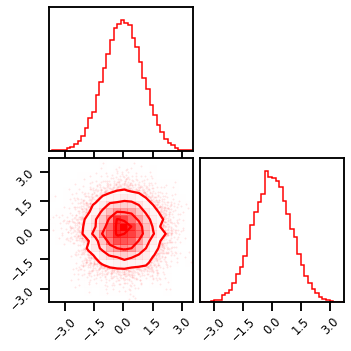

In [16]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

In [17]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

In [18]:
# initialize base distribution
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))


rbig_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

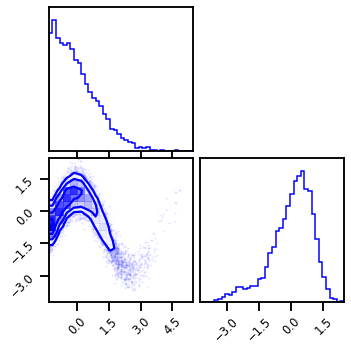

In [19]:
# inverse cascade
X_approx = rbig_model.inverse(X_g)

# plot
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

In [20]:
from rbig_jax.data import generate_2d_grid

In [21]:
# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

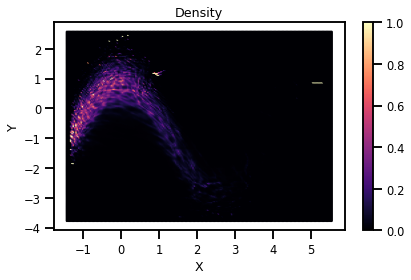

In [22]:
from matplotlib import cm

cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
title = "Density"

fig, ax = plt.subplots()
h = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.show()

#### Sampling

In [23]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 6.87 s, sys: 1.07 s, total: 7.95 s
Wall time: 3.98 s


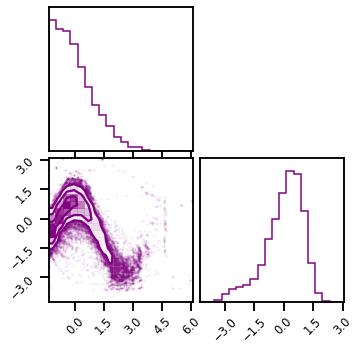

In [24]:
fig = corner.corner(X_samples, color="purple")

## Negative Log-Likelihood

#### Loss Function

In [25]:
# @jax.jit
# def nll_loss(X_gauss, X_ldj):
#     latent_prob = jax.scipy.stats.norm.logpdf(X_g)

#     log_prob = (latent_prob + X_ldj).sum(-1)
#     return - log_prob.mean()

#### Training

In [26]:
# %%time

# X_g_ = X
# X_ldj = np.zeros_like(X)
# nll_losses = []
# for iparam in params:

#     X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
#     X_ldj += iX_ldj

#     nll_losses.append(nll_loss(X_g_, X_ldj))

# chex.assert_tree_all_close(X_g_, X_g)

#### Plot Losses

In [27]:
# plt.figure()
# plt.plot(nll_losses)
# plt.title('Negative Log-Likelihood')
# plt.show()

### Negative Log-Likelihood (Change per layer)

In [28]:
# %%time

# X_g_ = X
# X_ldj = np.zeros_like(X)
# nll_change_losses = []
# for iparam in params:

#     X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
#     X_ldj += iX_ldj

#     nll_change_losses.append(nll_loss(X_g_, iX_ldj))

# chex.assert_tree_all_close(X_g_, X_g)

In [29]:
# plt.figure()
# plt.plot(nll_change_losses)
# plt.title('Change in Log-Likelihood')
# plt.show()